In [1]:
# base_dir = '/content/drive/MyDrive/CS760-project'
base_dir = '.'

import warnings
warnings.simplefilter('ignore')

# Imports

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
# torch

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
# from torch.utils.data import DataLoader

import os
import torchvision
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
# from torchvision.transforms import ToTensor
import torchvision.transforms as T
from torch.utils.data import random_split
import torch.utils.data as data
from torch.utils.data.dataloader import DataLoader

import matplotlib.pyplot as plt
from PIL import Image


import torch.nn as nn
import torch.nn.functional as F

import gensim
import gensim.downloader

In [4]:
# default font
plt.rcParams['font.size'] = 14

# default graph size
plt.rcParams['figure.figsize'] = (4,4)

# default graph grid
# plt.rcParams['axes.grid'] = True

# numpy precision
np.set_printoptions(suppress=True, precision=5)

# GPU Support

In [5]:
# device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Data Preparation

In [6]:
#data_dir_path = '/home/yohei/project/cs760/tiny-imagenet-200'
data_dir_path = 'D:/tiny-imagenet-200'

# data augmentation

def data_transform():
    return T.Compose([
        T.Resize(64),
        T.ColorJitter(brightness=0.2),
        T.RandomAffine(degrees=15, scale=(0.8,1.2), shear=10),
        T.RandomHorizontalFlip(),
        #T.RandomResizedCrop(64,scale=(0.7, 1.4)),
        T.ToTensor(),
    ])    
    
# create dataset object
train_dataset = ImageFolder(data_dir_path + '/train', transform=data_transform())
test_dataset = ImageFolder(data_dir_path + '/test', transform=T.ToTensor())

d = {}
f = open(data_dir_path+'/words.txt','r') 
while(1):
    try:
        key, val = f.readline().split("\t")
        d[key] = val[:-1]
    except Exception:
        break
        
for i in range(len(train_dataset.classes)):
    labels = d[train_dataset.classes[i]].split(',')
    train_dataset.classes[i] = labels[0]

In [7]:
targets = np.array(train_dataset.targets)
train_ind, temp_ind = train_test_split(np.arange(len(targets)),test_size=0.6,shuffle=True,stratify=targets)
test_ind, val_ind = train_test_split(temp_ind,test_size=(1/6),stratify=targets[temp_ind])

train_sampler = data.SubsetRandomSampler(train_ind)
val_sampler = data.SubsetRandomSampler(val_ind)

len(train_ind), len(val_ind)

(40000, 10000)

In [8]:
def count_similar(outputs, labels, n=10):
    count = 0

    for output, label in zip(outputs, labels):
        max_n_index = output.detach().numpy().argsort()[-n:][::-1]
        label = label.item()
        
        if label in max_n_index:
            count += 1

    return count

Label: 0 - goldfish


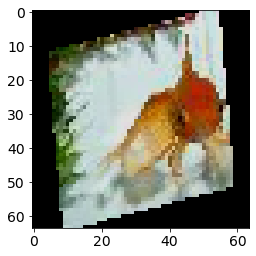

In [9]:
def show_example(img, label):
    print('Label: '+str(label)+' -',train_dataset.classes[label])
    plt.imshow(img.permute(1, 2, 0))
    
show_example(*train_dataset[101])

## Model Fitting

In [10]:
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)
    
    n = 1
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        # learning rate decay
        if (epoch+1) % (num_epochs/2) == 0:
            for parm in optimizer.param_groups:
                parm['lr'] /=  10 #3.16  #sqrt(10)
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0

        #訓練フェーズ: training phase
        net.train()

        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 勾配の初期化: initalize the gradient
            optimizer.zero_grad()

            # 予測計算: calc output
            outputs = net(inputs)

            # 損失計算: calc loss
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 勾配計算: calc gradient
            loss.backward()

            # パラメータ修正: parameter 
            optimizer.step()
            
            train_acc += count_similar(outputs, labels, n)

        #予測フェーズ: test phase
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 予測計算: calc prediction
            outputs = net(inputs)

            # 損失計算: calc loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            val_acc += count_similar(outputs, labels, n)
        
        avg_train_loss = train_loss/len(train_ind)
        avg_train_acc = train_acc/len(train_ind)
        avg_val_loss = val_loss/len(val_ind)
        avg_val_acc = val_acc/len(val_ind)
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

## Model Performance

In [11]:
# 学習ログ解析: the log for learning

def evaluate_history(history):
    #損失と精度の確認: loss and accuracy
    print(f'Initial: loss: {history[0,3]:.5f} accuracy: {history[0,4]:.5f}') 
    print(f'Final: loss: {history[-1,3]:.5f} accuracy: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 5

    # 学習曲線の表示 (損失): learning curve (loss)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='Training')
    plt.plot(history[:,0], history[:,3], 'k', label='Test(Val)')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('# of recursion')
    plt.ylabel('Loss')
    plt.title('Learning Curve (Loss)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度): learning curve (accuracy)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='Training')
    plt.plot(history[:,0], history[:,4], 'k', label='Test(Val)')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('# of recursion')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve (Accuracy)')
    plt.legend()
    plt.show()

In [13]:
# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

## Data Pipelines

In [14]:
#batch_size = 100
batch_size = 64

# DataLoarder of Training data
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

# DataLoarder of Test data
test_loader = DataLoader(train_dataset,  batch_size=batch_size, sampler=val_sampler) 

# Def Model

### Parameters

In [16]:
# output degree: 出力次元数
# number of classes: 分類先クラス数
n_output = len(classes)
#n_output = 200  # TODO: change to 500 (size of word vector) later

# number of nodes of hidden layer 隠れ層のノード数
n_hidden = 1024

print(f'n_hidden: {n_hidden} n_output: {n_output}')



n_hidden: 1024 n_output: 200


### CNN Model

In [17]:
class CNN(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2,2))
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.5)
        self.l1 = nn.Linear(2048, n_hidden) # 16*32*32
        self.l2 = nn.Linear(n_hidden, n_output)
        
        self.features = nn.Sequential(
            
            self.conv1,
            self.relu,
            self.maxpool,
            
            self.conv2,
            self.relu,
            self.bn2,
            self.maxpool,
            self.dropout1,
            
            self.conv3,
            self.relu,
            self.bn3,
            self.maxpool,
            self.dropout1,

        )

        self.classifier = nn.Sequential(
           self.l1,
           self.relu,
           self.dropout2,
           self.l2)

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

### Create model instance

In [18]:
# init randam, 乱数初期化
torch_seed()

# create model instanceモデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# summary of model:モデルのサマリー表示
summary(net,(batch_size,3,64,64),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─Sequential: 1-1                        [64, 32, 8, 8]            8,272
├─Conv2d: 1-2                            [64, 16, 64, 64]          1,216
├─ReLU: 1-3                              [64, 16, 64, 64]          --
├─MaxPool2d: 1-4                         [64, 16, 32, 32]          --
├─Conv2d: 1-5                            [64, 16, 32, 32]          2,320
├─ReLU: 1-6                              [64, 16, 32, 32]          --
├─BatchNorm2d: 1-7                       [64, 16, 32, 32]          32
├─MaxPool2d: 1-8                         [64, 16, 16, 16]          --
├─Dropout: 1-9                           [64, 16, 16, 16]          --
├─Conv2d: 1-10                           [64, 32, 16, 16]          4,640
├─ReLU: 1-11                             [64, 32, 16, 16]          --
├─BatchNorm2d: 1-12                      [64, 32, 16, 16]          64
├─M

In [19]:
# loss function: cross entropy損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss().to(device)

# learning step 学習率
lr = 0.001

# optimizser 最適化関数: 勾配降下法
optimizer = optim.Adam(net.parameters(),lr=lr)
#optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# epock 繰り返し回数
num_epochs = 40

# output 評価結果記録用
history = np.zeros((0,5))

# learning: 学習
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1/40], loss: 0.07966 acc: 0.02368 val_loss: 0.07537, val_acc: 0.04860


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2/40], loss: 0.07517 acc: 0.04523 val_loss: 0.07018, val_acc: 0.08430


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3/40], loss: 0.07217 acc: 0.06445 val_loss: 0.06857, val_acc: 0.09360


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4/40], loss: 0.07018 acc: 0.07712 val_loss: 0.06650, val_acc: 0.11000


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5/40], loss: 0.06875 acc: 0.08682 val_loss: 0.06720, val_acc: 0.11540


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6/40], loss: 0.06738 acc: 0.10075 val_loss: 0.06575, val_acc: 0.12640


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7/40], loss: 0.06615 acc: 0.10837 val_loss: 0.06330, val_acc: 0.14100


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8/40], loss: 0.06522 acc: 0.11488 val_loss: 0.06313, val_acc: 0.13680


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9/40], loss: 0.06432 acc: 0.12367 val_loss: 0.06139, val_acc: 0.15970


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10/40], loss: 0.06344 acc: 0.13225 val_loss: 0.06122, val_acc: 0.15950


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [11/40], loss: 0.06255 acc: 0.13790 val_loss: 0.06839, val_acc: 0.10530


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [12/40], loss: 0.06189 acc: 0.14745 val_loss: 0.05947, val_acc: 0.17540


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [13/40], loss: 0.06128 acc: 0.14888 val_loss: 0.06196, val_acc: 0.16350


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [14/40], loss: 0.06053 acc: 0.15987 val_loss: 0.06129, val_acc: 0.16880


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [15/40], loss: 0.05994 acc: 0.16428 val_loss: 0.06069, val_acc: 0.16700


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [16/40], loss: 0.05920 acc: 0.16930 val_loss: 0.06337, val_acc: 0.15450


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [17/40], loss: 0.05858 acc: 0.17752 val_loss: 0.06206, val_acc: 0.17220


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [18/40], loss: 0.05804 acc: 0.18272 val_loss: 0.05917, val_acc: 0.19120


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [19/40], loss: 0.05754 acc: 0.18798 val_loss: 0.05970, val_acc: 0.18820


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [20/40], loss: 0.05558 acc: 0.20735 val_loss: 0.05667, val_acc: 0.21520


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [21/40], loss: 0.05512 acc: 0.21220 val_loss: 0.05724, val_acc: 0.21410


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [22/40], loss: 0.05491 acc: 0.21245 val_loss: 0.05636, val_acc: 0.22050


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [23/40], loss: 0.05474 acc: 0.21338 val_loss: 0.05560, val_acc: 0.22780


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [24/40], loss: 0.05461 acc: 0.21463 val_loss: 0.05632, val_acc: 0.22400


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [25/40], loss: 0.05444 acc: 0.21798 val_loss: 0.05662, val_acc: 0.21840


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [26/40], loss: 0.05435 acc: 0.21882 val_loss: 0.05661, val_acc: 0.21720


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [27/40], loss: 0.05411 acc: 0.22075 val_loss: 0.05653, val_acc: 0.22440


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [28/40], loss: 0.05401 acc: 0.22057 val_loss: 0.05577, val_acc: 0.22880


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [29/40], loss: 0.05388 acc: 0.22237 val_loss: 0.05664, val_acc: 0.22670


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [30/40], loss: 0.05370 acc: 0.22570 val_loss: 0.05673, val_acc: 0.22410


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [31/40], loss: 0.05364 acc: 0.22620 val_loss: 0.05586, val_acc: 0.22980


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [32/40], loss: 0.05356 acc: 0.22495 val_loss: 0.05665, val_acc: 0.22370


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [33/40], loss: 0.05356 acc: 0.22598 val_loss: 0.05591, val_acc: 0.22970


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [34/40], loss: 0.05332 acc: 0.22900 val_loss: 0.05585, val_acc: 0.22690


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [35/40], loss: 0.05332 acc: 0.22915 val_loss: 0.05624, val_acc: 0.22680


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [36/40], loss: 0.05309 acc: 0.23312 val_loss: 0.05626, val_acc: 0.22280


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [37/40], loss: 0.05303 acc: 0.23108 val_loss: 0.05676, val_acc: 0.22670


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [38/40], loss: 0.05315 acc: 0.23228 val_loss: 0.05583, val_acc: 0.23080


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [39/40], loss: 0.05281 acc: 0.23530 val_loss: 0.05667, val_acc: 0.22540


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [40/40], loss: 0.05263 acc: 0.23465 val_loss: 0.05589, val_acc: 0.23180


In [20]:
torch.save(net.state_dict(), './cnn_best_so_far_40epoch.pth')

Initial: loss: 0.07537 accuracy: 0.04860
Final: loss: 0.05589 accuracy: 0.23180


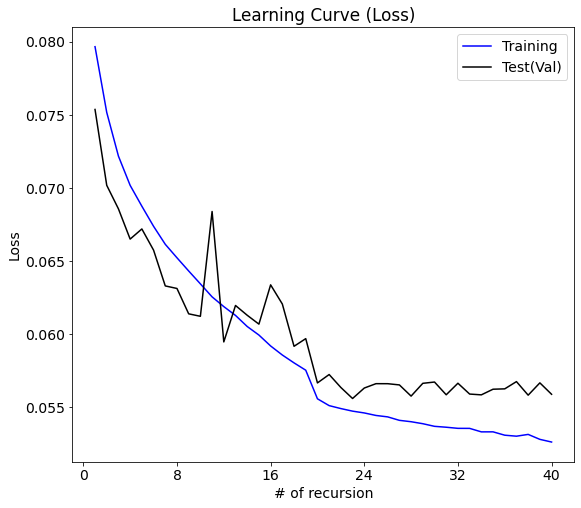

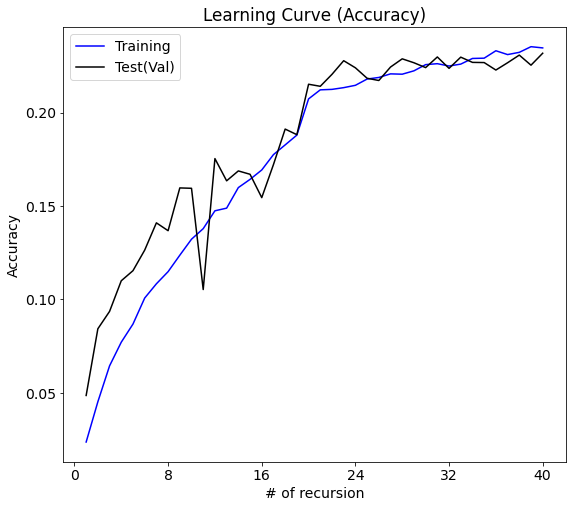

In [21]:
# 評価
evaluate_history(history)